## Cycle GAN (Zhu, Jun-Yan, et al., 2017)
- unpaired한 image to image translation을 하기 위한 GAN의 종류
- GAN을 학습하면 이론적으로 Pg = Pdata가 되는 특성 이용
- 만약 그냥 말 사진을 random noise 처럼 넣고 얼룩말 사진을 real_data로 넣으면 GAN의 특성에 의해 generator는 말을 얼룩말처럼 바꿔주지 않을까?
- 근데 단순하게 GAN으로만 하기에는 highly under-constrained
- 말->얼룩말 generator에 추가하여 얼룩말->말 generator를 하나 더 만들고 얼룩말 처럼 바뀐 말 사진을 다시 자기 자신(말)이 나오게 학습한다면 좀 더 constrained
- 이에 따라 discriminator도 말->얼룩말 방향 반대로 얼룩말->말 방향으로 추가

#### 그냥 GAN은

<img src = "./etc/gan.png" width = "200">

#### Cyclic하게 바꾸면 다음과 같음

<img src="./etc/cycle_gan_1.png" width="200">

#### 그리고 말이 얼룩말로 generate 되었다가 다시 돌아왔을때 원래 말 사진과 비슷해야하므로 cycle-consistency loss를 줌

<img src="./etc/cycle_gan_2.png" width="600">

reference
- Zhu, Jun-Yan, et al. "Unpaired image-to-image translation using cycle-consistent adversarial networks." arXiv preprint arXiv:1703.10593 (2017).
- He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
- https://arxiv.org/pdf/1607.08022.pdf (instance normalization, Dmitry Ulyanov et al. 2016)
- https://github.com/LynnHo/CycleGAN-Tensorflow-PyTorch

In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import instance_norm

In [2]:
def read_jpg(directory):
    file_dir = os.getcwd() + '/horse_zebra/horse2zebra/' + directory

    file_list = os.listdir(file_dir)
    file_arr = np.zeros(shape = [len(file_list), 256, 256, 3])
        
    for idx, file in enumerate(file_list):
        try:
            jpgfile = Image.open(file_dir + file)
            file_arr[idx] = np.asarray(jpgfile)
        except:
            continue
    return file_arr

In [3]:
# batch 짤라서 넣기
class DataIterator:
    def __init__(self, data, batch_size):
        self.data = data
        self.batch_size = batch_size
        self.iter = self.make_random_iter()
    
    def make_random_iter(self):
        splits = np.arange(self.batch_size, len(self.data), self.batch_size)
        it = np.split(np.random.permutation(len(self.data)), splits)
        return iter(it)
    
    def next_batch(self):
        try:
            idxs = next(self.iter)
        except StopIteration:
            self.iter = self.make_random_iter()
            idxs = next(self.iter)
        X = [self.data[i] for i in idxs]
        return np.array(X)

In [4]:
horse = read_jpg('trainA/')
zebra = read_jpg('trainB/')

In [5]:
horse = horse/255*2-1
zebra = zebra/255*2-1

In [6]:
batch_size = 8

In [7]:
data_train_h = DataIterator(horse, batch_size)
data_train_z = DataIterator(zebra, batch_size)

#### 중요 포인트!! - instance normalization(Dmitry Ulyanov et al. 2016)
- 보통 normalization으로 batch normalization을 사용하나 여기서는 instance normalization을 사용했으며 더 성능이 좋음
- batch normalization과의 차이는 아래의 식과 같이 normaliz

In [8]:
def conv(input_, out_dim, kernel, stride, name, is_norm = True):
    with tf.variable_scope(name):
        if is_norm:
            h = tf.layers.conv2d(input_, out_dim, kernel_size=kernel, strides=stride, padding='SAME', kernel_initializer=tf.random_normal_initializer(stddev=0.02),use_bias=False)
            out= instance_norm(h)
        else:
            out = tf.layers.conv2d(input_, out_dim, kernel_size=kernel, strides=stride, padding='SAME', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
            
        return out
            
def conv_transpose(input_, out_dim, kernel, stride, name, is_norm = True):
    with tf.variable_scope(name):
        if is_norm:
            h = tf.layers.conv2d_transpose(input_, out_dim, kernel_size=kernel, strides=stride, padding='SAME', kernel_initializer=tf.random_normal_initializer(stddev=0.02),use_bias=False)
            out = instance_norm(h)
        else:
            out = tf.layers.conv2d_transpose(input_, out_dim, kernel_size=kernel, strides=stride, padding='SAME', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        
        return out

def residual_block(input_, out_dim):
    
    for i in range(6):
        y = tf.nn.relu(conv(input_, out_dim, 3, 1, name='r_1_'+str(i+1), is_norm=False))
        y = conv(y, out_dim, 3, 1, name='r_2_'+str(i+1), is_norm=False)
        y = tf.nn.relu(y + input_)
        input_=y
        
    return y

#### 중요 포인트!! - residual block
- CNN 학습할때 deep하게 쌓아도 성능이 좋아지기는 커녕 안좋을 수 있음
- deep하게 쌓는 효과를 제대로 보려고 다음과 같은 residual block 형태로 쌓음 => resnet(He, Kaiming, et al., 2016)
- 처음에 이거 안하고 학습했는데 절대 성능 안나옴...

<img src = "./etc/resnet.png">

In [9]:
dim = 16

#### 기본적인 구조는 DCGAN에 Residual block 추가한것... 논문에 구조가 구체적으로 명시되어 있음

In [13]:
def G(z, reuse=False): #generator, discriminator 모두 두번 이상씩 사용하므로 reuse 걸어준다
    with tf.variable_scope('G',reuse=reuse):
        h1 = tf.nn.relu(conv(z, dim*2, 7, 1, name='g_1'))
        h2 = tf.nn.relu(conv(h1, dim*4, 3, 2, name='g_2'))
        h3 = tf.nn.relu(conv(h2, dim*8, 3, 2, name='g_3'))
        h4 = residual_block(h3, dim*8)
        h5 = tf.nn.relu(conv_transpose(h4, dim*4, 3, 2, name='g_5'))
        h6 = tf.nn.relu(conv_transpose(h5, dim*2, 3, 2, name='g_6'))
        out = tf.nn.tanh(conv_transpose(h6, 3, 7, 1, name='g_out', is_norm=False))
        
        return out 

def F(z, reuse=False):
    with tf.variable_scope('F',reuse=reuse):
        h1 = tf.nn.relu(conv(z, dim*2, 7, 1, name='f_1'))
        h2 = tf.nn.relu(conv(h1, dim*4, 3, 2, name='f_2'))
        h3 = tf.nn.relu(conv(h2, dim*8, 3, 2, name='f_3'))
        h4 = residual_block(h3, dim*8)
        h5 = tf.nn.relu(conv_transpose(h4, dim*4, 3, 2, name='f_5'))
        h6 = tf.nn.relu(conv_transpose(h5, dim*2, 3, 2, name='f_6'))
        out = tf.nn.tanh(conv_transpose(h6, 3, 7, 1, name='f_out', is_norm=False))
        
        return out     
    
    
def DY(input_, reuse = False):
    with tf.variable_scope('DY', reuse=reuse):
        h0 = tf.nn.leaky_relu(conv(input_, dim*4, 4 ,2, name='dy_0', is_norm=False))
        h1 = tf.nn.leaky_relu(conv(h0, dim*8, 4, 2, name='dy_1'))
        h2 = tf.nn.leaky_relu(conv(h1, dim*16, 4, 2, name='dy_2'))
        h3 = tf.nn.leaky_relu(conv(h2, dim*32, 4, 2, name='dy_3'))
        out = conv(h3, 1, 4, 1, name='dy_out', is_norm=False)
                               
        return out
    
def DX(input_, reuse = False):
    with tf.variable_scope('DX', reuse=reuse):
        h0 = tf.nn.leaky_relu(conv(input_, dim*4, 4 ,2, name='dx_0', is_norm=False))
        h1 = tf.nn.leaky_relu(conv(h0, dim*8, 4, 2, name='dx_1'))
        h2 = tf.nn.leaky_relu(conv(h1, dim*16, 4, 2, name='dx_2'))
        h3 = tf.nn.leaky_relu(conv(h2, dim*32, 4, 2, name='dx_3'))
        out = conv(h3, 1, 4, 1, name='dx_out', is_norm=False)
                               
        return out

In [14]:
tf.reset_default_graph()
x = tf.placeholder(dtype=tf.float32, shape = [None, 256, 256, 3])
y = tf.placeholder(dtype=tf.float32, shape = [None, 256, 256, 3])

In [15]:
gx = G(x)
dgx = DY(gx)
dy = DY(y, reuse=True)

fy = F(y)
dfy = DX(fy)
dx = DX(x, reuse=True)

fgx = F(gx,reuse=True)
gfy = G(fy,reuse=True)

#### 처음에 그냥 GAN 학습하듯이 뉴럴넷 태워서 sigmoid_cross_entropy 계산했었는데, 결국 논문이 한대로 mse를 loss로 줌

In [16]:
# min log(1 - D(G(Z))) => max D(G(Z))
# g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dgx, labels=tf.ones_like(dgx)))
# f_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dfy, labels=tf.ones_like(dfy)))
g_loss = tf.losses.mean_squared_error(dgx, tf.ones_like(dgx))
f_loss = tf.losses.mean_squared_error(dfy, tf.ones_like(dfy))

# max log(D(X)) + log(1-D(G(Z)))
# dy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dy, labels=tf.ones_like(dy))) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dgx, labels=tf.zeros_like(dgx)))
# dx_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dx, labels=tf.ones_like(dx))) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dfy, labels=tf.zeros_like(dfy)))
dy_loss = tf.losses.mean_squared_error(dy, tf.ones_like(dy)) + tf.losses.mean_squared_error(dgx, tf.zeros_like(dgx))
dx_loss = tf.losses.mean_squared_error(dx, tf.ones_like(dx)) + tf.losses.mean_squared_error(dfy, tf.zeros_like(dfy))


#cycle_loss
cyc_loss_1 = tf.losses.absolute_difference(x,fgx)
cyc_loss_2 = tf.losses.absolute_difference(y,gfy)
cyc_loss = 10*cyc_loss_1 + 10*cyc_loss_2

In [17]:
g_adam = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)

dy_adam = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
dx_adam = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)

In [18]:
g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'G')
f_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'F')
dy_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DY')
dx_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DX')
gf_vars = g_vars+f_vars

In [19]:
train_op_g = g_adam.minimize(g_loss+f_loss+cyc_loss, var_list=gf_vars)

train_op_dy = dy_adam.minimize(dy_loss, var_list=dy_vars)
train_op_dx = dx_adam.minimize(dx_loss, var_list=dx_vars)

In [26]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

Epoch은 논문에서 200번 돌렸다해서

In [27]:
n_epoches = 200
n_batches = 125

In [28]:
try:
    for i in range(n_epoches):
        for j in range(n_batches):
            batch_x, batch_y = data_train_h.next_batch(), data_train_z.next_batch()
            sess.run([train_op_g, train_op_dy, train_op_dx], feed_dict={x: batch_x, y:batch_y})
        print_g, print_f, print_dy, print_dx, print_cyc = sess.run([g_loss, f_loss, dy_loss, dx_loss, cyc_loss], feed_dict={x: batch_x, y:batch_y})
        
        print('g_loss = '+str(print_g))
        print('dy_loss = '+str(print_dy))
        print('dx_loss = '+str(print_dx))
        
        print('')
except KeyboardInterrupt:
    print('Stop Iterations')

g_loss = 0.40267786
dy_loss = 0.5316552
dx_loss = 0.48898476

g_loss = 0.32705468
dy_loss = 0.44491172
dx_loss = 0.47279584

g_loss = 0.31741172
dy_loss = 0.45388556
dx_loss = 0.47677186

g_loss = 0.35749942
dy_loss = 0.41110754
dx_loss = 0.46471134

g_loss = 0.34241658
dy_loss = 0.46528602
dx_loss = 0.4087335

g_loss = 0.3495292
dy_loss = 0.3113493
dx_loss = 0.41419455

g_loss = 0.538326
dy_loss = 0.30929422
dx_loss = 0.3787267

g_loss = 0.33786336
dy_loss = 0.39813524
dx_loss = 0.42686695

g_loss = 0.5587466
dy_loss = 0.18706644
dx_loss = 0.3700255

g_loss = 0.49321792
dy_loss = 0.23542775
dx_loss = 0.39549494

g_loss = 0.3105111
dy_loss = 0.33554965
dx_loss = 0.3822416

g_loss = 0.2617176
dy_loss = 0.40735054
dx_loss = 0.41574097

g_loss = 1.8294892
dy_loss = 0.88324714
dx_loss = 0.34502393

g_loss = 2.068564
dy_loss = 1.5743976
dx_loss = 0.39389443

g_loss = 0.6581929
dy_loss = 0.18860166
dx_loss = 0.4835105

g_loss = 0.6478435
dy_loss = 0.20499353
dx_loss = 0.4415574

g_loss = 0.7

In [29]:
horse_t = read_jpg('testA/')

In [83]:
i=20
gen_horse = (sess.run(gx, feed_dict={x:horse_t[i:i+1]/255*2-1})+1)/2

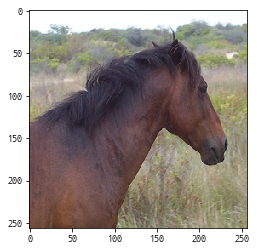

In [84]:
plt.imshow(horse_t[i:i+1].reshape(256,256,3)/255)

#### 헐... 대박

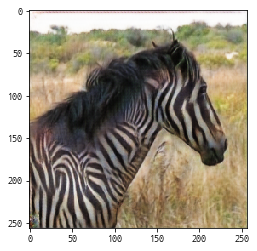

In [85]:
plt.imshow(gen_horse.reshape(256,256,3))

In [33]:
i=12
gen_horse = (sess.run(gx, feed_dict={x:horse_t[i:i+1]/255*2-1,phase:False})+1)/2

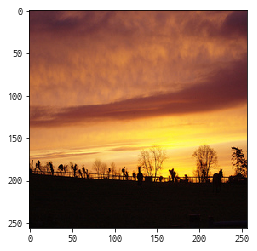

In [34]:
plt.imshow(horse_t[i:i+1].reshape(256,256,3)/255)

### .... 망

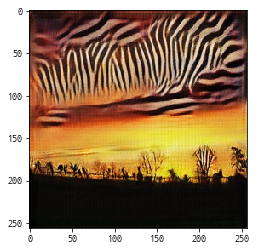

In [35]:
plt.imshow(gen_horse.reshape(256,256,3))